# Sketching Data Distributions with T-Digests

In [14]:
# spark dataframe support
from pyspark.sql.functions import *
from pyspark.sql.types import *

# t-digest dataframe support
from isarnproject.sketches.udaf.tdigest import *

# plotting support
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [15]:
raw = [[np.asscalar(x)] for x in np.random.gamma(1.5,scale=0.3,size=10000)]
data = spark.sparkContext.parallelize(raw, 3).toDF(StructType([StructField("x", DoubleType())]))
data.show(5)

+-------------------+
|                  x|
+-------------------+
| 0.8265025388255672|
|0.42592305706878597|
|  0.759321609616235|
|0.14057124538160454|
|0.26302954006921575|
+-------------------+
only showing top 5 rows



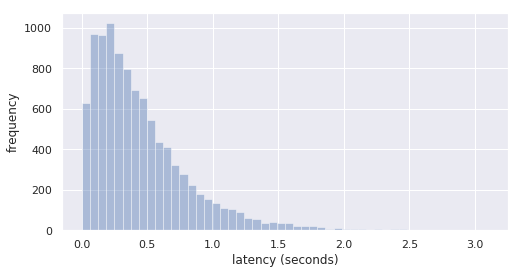

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
ax.axes.xaxis.set_label_text("latency (seconds)")
ax.axes.yaxis.set_label_text("frequency")
sns.distplot(raw, kde=False, ax=ax)

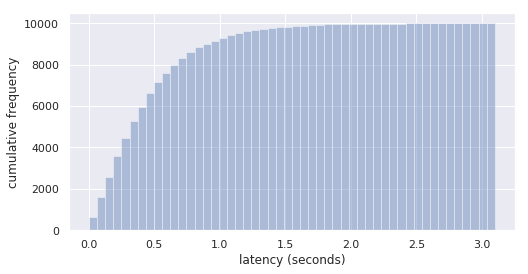

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
ax.axes.xaxis.set_label_text("latency (seconds)")
ax.axes.yaxis.set_label_text("cumulative frequency")
sns.distplot(raw, kde=False, hist_kws={'cumulative': True}, ax=ax)

In [18]:
agg = data.agg(tdigestDoubleUDAF("x", delta=0.1))
agg.show()

+--------------------+
|      tdigestudaf(x)|
+--------------------+
|TDigestSQL(TDiges...|
+--------------------+



In [19]:
tdigest = agg.first()[0]
type(tdigest)

isarnproject.sketches.udt.tdigest.TDigest

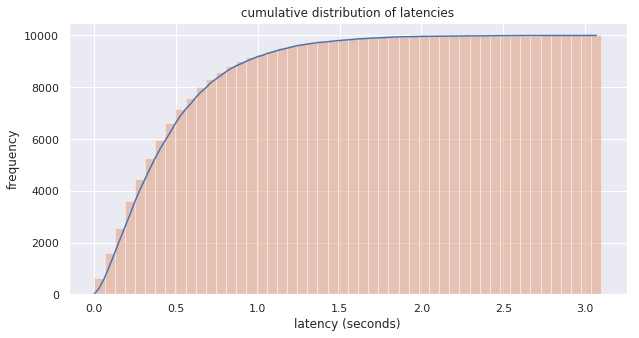

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
xmax = tdigest.cdfInverse(1.0)
xdata = [(xmax * x/100.0) for x in xrange(100)]
ydata = [(tdigest.cdf(x) * tdigest.mass()) for x in xdata]
xydata = pd.DataFrame({"x": xdata,"y": ydata})
sns.lineplot(data=xydata, x = "x", y = "y", ax=ax)
ax.axes.xaxis.set_label_text("latency (seconds)")
ax.axes.yaxis.set_label_text("frequency")
ax.axes.set_title("cumulative distribution of latencies")
sns.distplot(raw, kde=False, hist_kws={'cumulative': True}, ax=ax)

In [21]:
quantiles = [0.5, 0.9, 0.99, 0.999]
qx = [tdigest.cdfInverse(x) for x in quantiles]
pd.DataFrame(
    {
        "quantile": quantiles,
        "x": qx
    }
)

,quantile,x
0,0.500,0.353441
1,0.900,0.924729
2,0.990,1.716083
3,0.999,2.471610


In [22]:
synthetic = [tdigest.sample() for x in xrange(10000)]
synthetic[:5]

[0.4240493155368075,
 0.13432747837537476,
 0.9039343404281196,
 1.2833087028183154,
 0.32560822470498574]

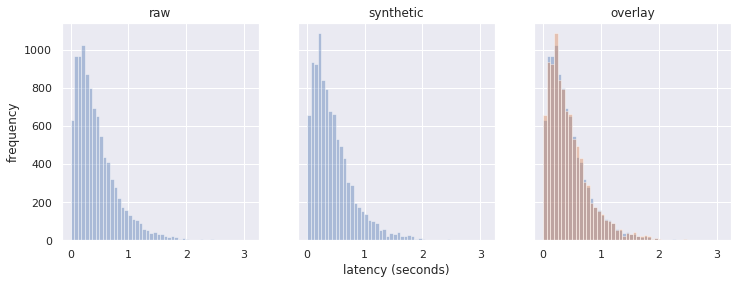

In [23]:
fig, ax = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(12, 4)
ax[1].axes.xaxis.set_label_text("latency (seconds)")
ax[0].axes.yaxis.set_label_text("frequency")
ax[0].axes.set_title("raw")
ax[1].axes.set_title("synthetic")
ax[2].axes.set_title("overlay")
sns.distplot(raw, kde=False, ax=ax[0])
sns.distplot(synthetic, kde=False, ax=ax[1])
sns.distplot(raw, kde=False, ax=ax[2])
sns.distplot(synthetic, kde=False, ax=ax[2])

In [24]:
def estimate_pdf(tdigest, x):
    x1 = x + 0.01
    y = tdigest.cdf(x)
    y1 = tdigest.cdf(x1)
    return (y1-y)/(x1-x)

In [25]:
estimate_pdf(tdigest, 0.5)

0.8487092313045

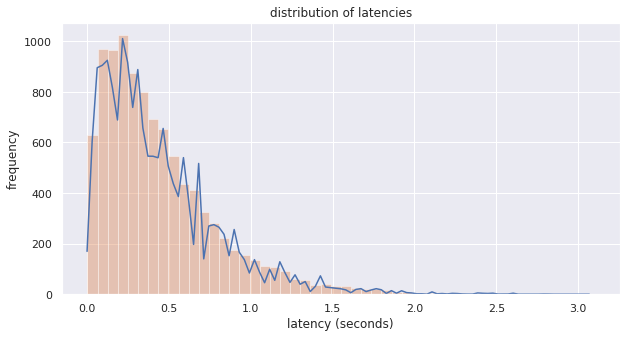

In [26]:
magic_scale = 550  # I'm not even sorry
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
xmax = tdigest.cdfInverse(1.0)
xdata = [(xmax * x/100.0) for x in xrange(100)]
ydata = [magic_scale * estimate_pdf(tdigest,x) for x in xdata]
xydata = pd.DataFrame({"x": xdata,"y": ydata})
sns.lineplot(data=xydata, x = "x", y = "y", ax=ax)
ax.axes.xaxis.set_label_text("latency (seconds)")
ax.axes.yaxis.set_label_text("frequency")
ax.axes.set_title("distribution of latencies")
sns.distplot(raw, kde=False, ax=ax)